In [1]:
import pandas as pd

from scipy.optimize import fsolve
from openpyxl import load_workbook

import numpy as np
import uncertainties as uc

pd.options.display.float_format ='{:,.3f}'.format
import matplotlib.pyplot as plt
import matplotlib.colors as clr

%matplotlib inline  
from IPython.display import Image
from IPython.core.display import HTML 

from scipy import integrate
import scipy.stats as stats
from uncertainties import ufloat
from uncertainties import unumpy

from scipy.stats import gmean

%run Utility_Functions.ipynb

## Methods and Statistics
Ranges and values with ± are given as 1 standard error of the values.

Ranges in cases of large uncertainty are not necessarily symmetrical.

Boxplot showing the quartiles (25%-75%) and the median (orange horizontal line). In addition the vertical lines extending to the most extreme, non-outlier data points

# Skin cells

The skin is composed of two main layers:
1. Epidermis - the outer layer. Contain tens of layers separated to 4-5 domains. Populated mostly by nucleated keratinocytes. The top 15-20 layers of cells are called Startum Corneum and are containing corneocytes, dead keratinocytes cells
2. Dermis - the inner layer. Comprise of a connective tissue. The main cells populting it are fibroblast, responsible for the secration of the extracellular matrix. 


## Skin total mass and cellualr mass
We use data summarized in [ICRP, 2002](http://www.icrp.org/publication.asp?id=ICRP%20Publication%2089) regarding the surface area and depth of the different segments of the body to determine the overall mass of the skin parts. We then use data from [Snyder et al., 1975](http://www.icrp.org/publication.asp?id=ICRP%20Publication%2023) regarding the potasium concentraion to asses the fraction of cellular mass based on a furmola from [Wang et al., 2004](https://www.ncbi.nlm.nih.gov/pubmed/14532167)

In [2]:
skin_prop_data = pd.read_excel('Skin_cells_data.xlsx','Skin_properties',index_col=0,usecols = range(0,8),skipfooter = 1)
#assigning the data including its uncertatinies to a new dataframe:
skin_prop = pd.DataFrame(index = skin_prop_data.index) 

for parmeter in ['epidermis thickness (µm)','dermal thickness (µm)','total surface area (m^2)']:
    skin_prop[parmeter] = unumpy.uarray(skin_prop_data[parmeter],skin_prop_data[parmeter +' SD'])
    
#calculating the total mass using the denisity. Translating all the length units to cm
skin_prop['epidermis total mass (g)'] = skin_prop_data['mass density (g/cm^3)'] *(skin_prop['epidermis thickness (µm)']*10**(-4))*(skin_prop['total surface area (m^2)']*10**4) 
skin_prop['dermis total mass (g)'] = skin_prop_data['mass density (g/cm^3)'] *(skin_prop['dermal thickness (µm)']*10**(-4))*(skin_prop['total surface area (m^2)']*10**4) 

#creating a data frame which indices are dermis/epidermis and contain the total mass of them
skin_part_mass=pd.DataFrame(skin_prop[['epidermis total mass (g)','dermis total mass (g)']].sum(axis=0)).rename(index={'epidermis total mass (g)':'epidermis',
                                                                                                                         'dermis total mass (g)':'dermis'}, 
                                                                                                               columns={0:'total mass (g)'})


In [3]:
#uploading the data regarding the cellular mass of the skin  
mass_data = pd.read_excel('Skin_cells_data.xlsx','Cellular_mass',index_col=0, usecols=range(6))

#assuming the variance in the estimate for the dermis and the epidermis is similiar
mass_data.loc[['Epidermis potassium','Dermis potassium'],'SD'] = mass_data.loc[['Epidermis potassium','Dermis potassium'],'value']*mass_data.loc['Whole skin potassium','SD']/mass_data.loc['Whole skin potassium','value']

# combining the values and uncertainties for computations. 
# cmdt =cellular mass data
cmdt = pd.Series(unumpy.uarray(mass_data['value'],mass_data['SD']), index =mass_data.index ) #cell mass data

#using Wang's formula to conclude the total cellular mass in each of the compartments
skin_part_mass['potassium content (g)'] = cmdt[['Epidermis potassium','Dermis potassium']].values

skin_part_mass['cellular mass (g)']= 1000*(skin_part_mass['potassium content (g)']/cmdt['potassium molar mass'])*cmdt['cell mass/potassium conc.']*1000 
#convert from mmol to mol, and the results from kg to g
skin_part_mass

,total mass (g),potassium content (g),cellular mass (g)
epidermis,121+/-20,0.46+/-0.15,(1.1+/-0.4)e+02
dermis,(3.21+/-0.31)e+03,1.1+/-0.4,(2.6+/-0.9)e+02


## Epidermal cells numbers and mass
Combining the data regarding the surface area of the body (from [ICRP, 2002](http://www.icrp.org/publication.asp?id=ICRP%20Publication%2089)) with measurements of cellular area density from [Bauer et al., 2001](https://www.ncbi.nlm.nih.gov/pubmed/11180009) and [Hoath and Leahy, 2003](https://www.sciencedirect.com/science/article/pii/S0022202X1530556X) and [Bergstresser et al., 1978](https://www.sciencedirect.com/science/article/pii/S0022202X15452534) we can get an estimate for number of the different cells in the epidermis. We also use the data regarding the prevalence of melanocytes from [Quevedo et al., 1975](https://www.ncbi.nlm.nih.gov/pubmed/1211434) to estimates their contributions.

We integrate the numbers of cells with their mean mass (taken from [Bergstresser et al., 1978](https://www.sciencedirect.com/science/article/pii/S0022202X15452534)) to get an estimate for the total cellular mass, which we can compare to the one we got from the potassium content. 

In [4]:
surface_density_data = pd.read_excel('Skin_cells_data.xlsx','Surface_density',index_col=0, usecols=range(7))

#fill in the entries of the table using the given data. Note that corneocytes aren't included in the nucleated cells.

#using the average of Bergstresser et al., 1978 and Bauer et al., 2001 estimates and calculating SEM from them.
nucSD = surface_density_data.loc['total nucelated cells','surface density cells/mm^2'].std()/np.sqrt(surface_density_data.loc['total nucelated cells'].index.size)
surface_density_data=surface_density_data.groupby('cells').mean()
surface_density_data.loc['total nucelated cells','SD']= nucSD

surface_density_data.loc['Langerhans cells','% of nucleated cells'] =surface_density_data.loc['Langerhans cells','surface density cells/mm^2']/ surface_density_data.loc['total nucelated cells','surface density cells/mm^2']
surface_density_data.loc['melanocytes',['surface density cells/mm^2','SD']] =surface_density_data.loc['melanocytes','% of nucleated cells']*surface_density_data.loc['total nucelated cells',['surface density cells/mm^2','SD']]

surface_density_data.loc['keratinocytes','% of nucleated cells'] = 1-surface_density_data.loc[['Langerhans cells','melanocytes'],'% of nucleated cells'].sum(axis=0) 
surface_density_data.loc['keratinocytes',['surface density cells/mm^2','SD']] = surface_density_data.loc['keratinocytes','% of nucleated cells']*surface_density_data.loc['total nucelated cells',['surface density cells/mm^2','SD']]
surface_density_data.loc['corneocytes','SD'] = surface_density_data.loc['corneocytes','surface density cells/mm^2']*surface_density_data.loc['total nucelated cells','SD']/surface_density_data.loc['total nucelated cells','surface density cells/mm^2']


#combining the values with the error for further computations
surface_density_data['density + error (cells/mm^2)'] = unumpy.uarray(surface_density_data['surface density cells/mm^2'],surface_density_data['SD'])
surface_density_data['total cells'] = skin_prop['total surface area (m^2)'].sum(axis=0)*10**6*surface_density_data['density + error (cells/mm^2)']  #usingt the total surface area and translating m^2 to mm^2

#extracting the mean celllar mass of nucleated and corneocytes, according to Bergstresser et al., 1978 data
nuc_cell_mass = ufloat(mass_data.loc['nucleated cell volume','value'],mass_data.loc['nucleated cell volume','SD'])*1.05 #assuming density of 1.05g/cm^3 as for other cells. results in pg.
cor_cell_mass = ufloat(mass_data.loc['corneocytes cell volume','value'],mass_data.loc['corneocytes cell volume','SD'])*1.05 

#using the mean mass to compute the total mass of each of the cell type
surface_density_data['cellular mass']=0
surface_density_data.loc[surface_density_data['nucleated']==1,'cellular mass'] = nuc_cell_mass*surface_density_data.loc[surface_density_data['nucleated']==1,'total cells']/10**12 #translating pg to grams
surface_density_data.loc['corneocytes','cellular mass'] = cor_cell_mass*surface_density_data.loc['corneocytes','total cells']/10**12


print('Number of total epidermal nucleated cells: {:0.1eP}'.format(surface_density_data.loc['total nucelated cells','total cells']))
print('Average mass of epidermal nucleated cells: {:0.0fP} pg'.format(nuc_cell_mass))

print('____ _____ _____')

print('Total cellular mass of epidermal nucleated cells based on number estimate: {:0.0fP} g'.format(surface_density_data.loc['total nucelated cells','cellular mass']))
print('Total cellular mass of epidermal cells based on number estimate (including corneocytes): {:0.0fP} g'.format(surface_density_data.loc[['total nucelated cells','corneocytes'],
                                                                                                                                         'cellular mass'].sum(axis=0)))
print('Total cellular mass of the epidermis based potassium content: {:0.0fP} g'.format(skin_part_mass.loc['epidermis','cellular mass (g)']),
      'out of total mass of {:0.0fP} g'.format(skin_part_mass.loc['epidermis','total mass (g)']))



Number of total epidermal nucleated cells: (1.2±0.3)×10¹¹
Average mass of epidermal nucleated cells: 830±32 pg
____ _____ _____
Total cellular mass of epidermal nucleated cells based on number estimate: 97±22 g
Total cellular mass of epidermal cells based on number estimate (including corneocytes): 139±24 g
Total cellular mass of the epidermis based potassium content: 108±38 g out of total mass of 121±20 g


The two estimates for the cellular mass overlap, as they should. 

As kertinocytes dominant the cell population we focus on them. As corneocytes are essentially dead cells, we don't count them.

saving the results for future extraction.
:

In [5]:
skin = CellTypesResDF(['Epidermal cells','Dermal fibroblasts'])
skin.res.loc['Epidermal cells','number'] = surface_density_data.loc['total nucelated cells','total cells']

skin.res.loc['Epidermal cells','cell mass'] = nuc_cell_mass

skin.res.loc['Epidermal cells',
             'total cellular mass'] = surface_density_data.loc['total nucelated cells','cellular mass']
skin.print_params(['number','cell mass','total cellular mass'],'Epidermal cells')

Number of Epidermal cells is: (1.2±0.3)×10¹¹ cells
Cell mass of Epidermal cells is: 830±30 pg
Total cellular mass of Epidermal cells is: 100±20 grams


## Epidermal cells turnover
The lifespan of keratinocytes was estimated by integration of labeling measurement with modeling of the turnover through three distinguish compartments in the epidermis:
1. The germinative cell layer - the basal layer in which the cells are being produced.
2. The overlying viable epidermis - the layers in which the keratinocytes are still viable.
3. The Startum Corneum - the layers at the top that contain only dead cells (corneocytes)

We are interested in the lifespan that include only the viable compartments - e.g the first two.

During the 1970's-1980's several studies used estimates for the duration of the DNA synthesis (S-phase) and labeling indices, and the relation of cell density in them to estimate the turnover through the three compartments [Halprin, 1972](https://www.ncbi.nlm.nih.gov/pubmed/4551262), [Bergstresser and Taylor, 1977](https://www.ncbi.nlm.nih.gov/pubmed/871385), [Weinstein et al., 1984](https://www.ncbi.nlm.nih.gov/pubmed/6725985). We look at their values for the turnover and use the average of the main values as our reference.


Boxplot representing the distribution of the lifespan in the keratinocyte compartment
The main body of the boxplot showing the quartiles (25%-75%) and the median (green horizontal line)
The vertical lines extending to the most extreme, non-outlier data points


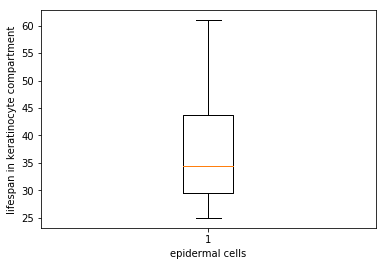

In [8]:
epi_to_data = pd.read_excel('Skin_cells_data.xlsx','epidermal_turnoevr',index_col=0, usecols=range(7))

#showing using boxplot
plt.boxplot(epi_to_data['keratinocyte compartment'])
plt.ylabel('lifespan in keratinocyte compartment')
plt.xlabel('epidermal cells');

print('Boxplot representing the distribution of the lifespan in the keratinocyte compartment')
print('The main body of the boxplot showing the quartiles (25%-75%) and the median (green horizontal line)')
print('The vertical lines extending to the most extreme, non-outlier data points')

As it easy to see, Halprin maximal estiamtes is very high relative to the other and therfore we remove it and calcaulate the average and standard error without it.
Using the lifespan and previous estimate we compute the total turnover rates:

In [9]:
skin.res.loc['Epidermal cells','lifespan'] = ufloat(epi_to_data.loc[epi_to_data['description']!='maximal',
                                                                    'keratinocyte compartment'].mean(),
                                                    epi_to_data.loc[epi_to_data['description']!='maximal',
                                                                    'keratinocyte compartment'].std()/np.sqrt(epi_to_data.loc[epi_to_data['description']!='maximal',
                                                                                                                              'keratinocyte compartment'].size))
#turnover = number/mass divided by the lifespan

skin.res.loc['Epidermal cells','cellular turnover rate'] = skin.res.loc['Epidermal cells','number']/skin.res.loc['Epidermal cells','lifespan']
skin.res.loc['Epidermal cells',
             'cellular mass turnover rate'] = skin.res.loc['Epidermal cells','total cellular mass']/skin.res.loc['Epidermal cells','lifespan']

skin.print_params(['lifespan','cellular turnover rate','cellular mass turnover rate'],'Epidermal cells')

Lifespan of Epidermal cells is: 31±4 days
Cellular turnover rate of Epidermal cells is: (3.7±0.9)×10⁹ cells per day
Cellular mass turnover rate of Epidermal cells is: 3.1±0.8 grams per day


## Dermal fibroblast

Estimated to be 0.1% of the cells in the body. They are responsible for the secreting of the dermal extracellular matrix.

### Dermal fibroblast numbers and mass
Repeating the estimates made in [Sender et al., 2016](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1002533) we use the cellular density in two parts of the dermis: papillary  and reticular.
Multiplying data regarding cellular density in the layers [Randolph and Simon, 1998](https://www.ncbi.nlm.nih.gov/pubmed/9740244), [Miller  et al., 2003](https://www.ncbi.nlm.nih.gov/pubmed/12930296)  with the general data regarding the surfcace area and thickness of the skin and the fraction of the two parts [McGrath et al., 2004](https://onlinelibrary.wiley.com/doi/10.1002/9781444317633.ch3)

In [10]:
derm_fib_data = pd.read_excel('Skin_cells_data.xlsx','dermal_fib_data',index_col=0, usecols=range(6))
derm_fib_data.head()

skin_prop['pap der thick'] = skin_prop['dermal thickness (µm)']* ufloat(derm_fib_data.loc['papillary dermis portion','value'],derm_fib_data.loc['papillary dermis portion','SD'])
skin_prop['ret der thick'] = skin_prop['dermal thickness (µm)']* ufloat(derm_fib_data.loc['reticular dermis portion','value'],derm_fib_data.loc['reticular dermis portion','SD'])

ret_den= ufloat(derm_fib_data.loc['mid dermis fibroblast density/skin unit volume','value'],derm_fib_data.loc['mid dermis fibroblast density/skin unit volume','SD'])
cv_ret = derm_fib_data.loc['mid dermis fibroblast density/skin unit volume','SD']/derm_fib_data.loc['mid dermis fibroblast density/skin unit volume','value']
#assuming similar fraction of uncertainty (CV)
pap_den = ufloat(derm_fib_data.loc['papillary fibroblast density/skin unit volume','value'],
                 derm_fib_data.loc['papillary fibroblast density/skin unit volume','value']*cv_ret)

#using the SA, depth and density to estimate the total number
skin_prop['papillary fibroblast'] = skin_prop['pap der thick']*skin_prop['total surface area (m^2)']*pap_den 
skin_prop['reticular fibroblast'] = skin_prop['ret der thick']*skin_prop['total surface area (m^2)']*ret_den 

#summing the numbers and saving it in the results:
skin.res.loc['Dermal fibroblasts','number'] = skin_prop['papillary fibroblast'].sum() + skin_prop['reticular fibroblast'].sum()


skin.res.loc['Dermal fibroblasts','cell mass'] = 1.05 *ufloat(derm_fib_data.loc['fibroblast volume','value'], 
                                                              derm_fib_data.loc['fibroblast volume','SD'])

skin.res.loc['Dermal fibroblasts',
             'total cellular mass'] = skin.res.loc['Dermal fibroblasts','cell mass']*skin.res.loc['Dermal fibroblasts','number']/10**12

skin.print_params(['number','cell mass','total cellular mass'] ,'Dermal fibroblasts')

Number of Dermal fibroblasts is: (3.8±1.6)×10¹⁰ cells
Cell mass of Dermal fibroblasts is: 2300±200 pg
Total cellular mass of Dermal fibroblasts is: 90±40 grams


### Dermal Fibroblast turnover

There is no direct measurment of the lifespan of human dermal fibroblast in-vivo , only irrelevant data from in-vitro expermints.
We therfore use the known data measured in mouse ([Ruchti et al., 1983](https://www.ncbi.nlm.nih.gov/pubmed/6883461)) to get an extrapolated estimate to serve as an upper bound for the turnover in human

In [11]:
skin.res.loc['Dermal fibroblasts','lifespan in rodents'] = ufloat(derm_fib_data.loc['mouse dermal fibroblast lifespan','value'],
                                                                  derm_fib_data.loc['mouse dermal fibroblast lifespan','SD'])

skin.res.loc['Dermal fibroblasts',
             'extrapolated cellular turnover rate'] = skin.res.loc['Dermal fibroblasts','number']/skin.res.loc['Dermal fibroblasts',
                                                                                                               'lifespan in rodents']

skin.res.loc['Dermal fibroblasts',
             'extrapolated cellular mass turnover rate'] = skin.res.loc['Dermal fibroblasts',
                                                                        'total cellular mass']/skin.res.loc['Dermal fibroblasts','lifespan in rodents']

skin.print_params(['lifespan in rodents','extrapolated cellular turnover rate',
                   'extrapolated cellular mass turnover rate'], 'Dermal fibroblasts')

Lifespan in rodents of Dermal fibroblasts is: 140±20 days
Extrapolated cellular turnover rate of Dermal fibroblasts is: (2.7±1.2)×10⁸ cells per day
Extrapolated cellular mass turnover rate of Dermal fibroblasts is: 0.6±0.3 grams per day


## Saving the results to excell

In [12]:
skin.export_to_excel('Summary.xlsx')